In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import tensorflow as tf
import pickle
import os
from importlib import reload

In [26]:
import dataset_utils
from glob import glob

In [27]:
reload(dataset_utils)

<module 'dataset_utils' from 'c:\\Users\\kzho904\\Documents\\GitHub\\P4P-mmWave\\MMWave_Radar_Human_Tracking_and_Fall_detection\\dataset_utils.py'>

In [28]:
bg_noise_dir = './data/03_09_2024_katie_pc_bg_noise/unique_bg_points.pkl'
with open(bg_noise_dir, 'rb') as file:
        background_data = pickle.load(file)

In [29]:
def background_subtraction(background_data, current_frame_data, threshold=0.1):
    filtered_data = []
    points_removed = []
    num_points_removed = 0
    for point in current_frame_data:
        # print(point)
        distances = np.linalg.norm(background_data[:, :3]- point[:3], axis =1)
        if np.min(distances) > threshold:
            filtered_data.append(point)
        else:
            num_points_removed +=1
            points_removed.append(point)
    return filtered_data

In [30]:
def parse_dataset(num_points, DATA_DIR):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob(os.path.join(folder, "train/*"))
        test_files = glob(os.path.join(folder, "test/*"))

        all_train_points=[]
        for f in train_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    all_train_points.append(bg_rm_arr)
                
                concatenated_train_points = np.concatenate(all_train_points, axis=0)
                # concatenated_train_points = background_subtraction(background_data, concatenated_train_points)
                np.random.seed(42)
                sampled_indices = np.random.choice(concatenated_train_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_train_points[sampled_indices].astype(np.float16)
                train_points.append(sampled_data)
                train_labels.append(i)
                # print(data)
                # print("loaded: {}".format(f))
                # print(num_points)
                # sampled_data = data.sample(num_points).to_numpy()
               
        all_test_points = []
        for f in test_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    all_test_points.append(bg_rm_arr)
                
                concatenated_test_points = np.concatenate(all_test_points, axis=0)
                # concatenated_test_points = background_subtraction(background_data, concatenated_test_points)
                np.random.seed(42)
                sampled_indices = np.random.choice(concatenated_test_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_test_points[sampled_indices].astype(np.float16)
                
                test_points.append(sampled_data)
                test_labels.append(i)
                # print(data)
                # print("loaded: {}".format(f))
                # print(num_points)
                # sampled_data = data.sample(num_points).to_numpy()
                # print(test_labels)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [31]:
DATA_DIR = "cluster_data/padded"
NUM_POINTS = 300
NUM_FRAMES = 3
NUM_CLASSES = 4
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS, DATA_DIR)

# Verify the shapes
print(f"train_points shape: {train_points.shape}")
print(f"test_points shape: {test_points.shape}")
print(f"train_labels shape: {np.array(train_labels).shape}")
print(f"test_labels shape: {np.array(test_labels).shape}")

processing class: jumping
processing class: picking_up
processing class: sitting
processing class: walking
train_points shape: (1073, 300, 5)
test_points shape: (269, 300, 5)
train_labels shape: (1073,)
test_labels shape: (269,)


In [32]:
print(CLASS_MAP)

{0: 'padded\\jumping', 1: 'padded\\picking_up', 2: 'padded\\sitting', 3: 'padded\\walking'}


In [33]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [34]:
train_size = 0.8
seed = 42
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points), seed=seed).map(PointNET.augment)
test_dataset = test_dataset.shuffle(len(test_points), seed=seed).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [96]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer

In [100]:
import tensorflow as tf
from tensorflow import data as tf_data
import keras
from keras import layers
import numpy as np

keras.utils.set_random_seed(seed=42)

def create_pointnet_model(input_shape, num_features, NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)

    # PointNet feature extraction
    x = tnet(inputs, num_features)
    
    # Convolutional layers
    x = conv_bn(x, 64)
    x = conv_bn(x, 64)
    x = conv_bn(x, 128)
    x = conv_bn(x, 1024)
    
    # GlobalMaxPooling1D
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Reshape((-1, 1024))(x)
    
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Flatten()(x)
    # Fully connected layer
    x = layers.Dense(256, activation='relu')(x)
    
    # Final dense layer
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet_lstm")
    return model

# Usage
input_shape = (NUM_POINTS, 5)  # Adjust this based on your input data
num_features = 5  # Features per point (R, v, x, y, SNR, in, if)

# model = create_pointnet_model(input_shape, num_features)
# model.summary()


In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os


In [38]:
INIT_TIMESTAMP = "19_09_2024_pointlstm_4_class_padded_bg_rm"
checkpoint_dir = os.path.join('model/checkpoints/', INIT_TIMESTAMP)
os.makedirs(checkpoint_dir, exist_ok=True)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [40]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best.weights.h5'),  # Save weights after each epoch
    save_weights_only=True,  # Save only weights, not the entire model
    save_best_only = True,
    verbose=1  # Print a message when saving
)

In [41]:


model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=[checkpoint_callback, early_stopping_callback]  
)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 6.4518 - sparse_categorical_accuracy: 0.6520
Epoch 1: val_loss improved from inf to 3.99318, saving model to model/checkpoints/19_09_2024_pointlstm_4_class_padded_bg_rm\best.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 6.4042 - sparse_categorical_accuracy: 0.6585 - val_loss: 3.9932 - val_sparse_categorical_accuracy: 0.9907
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 4.2205 - sparse_categorical_accuracy: 0.9724
Epoch 2: val_loss improved from 3.99318 to 3.97933, saving model to model/checkpoints/19_09_2024_pointlstm_4_class_padded_bg_rm\best.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 4.2207 - sparse_categorical_accuracy: 0.9719 - val_loss: 3.9793 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 4.2259 - sparse_categorical_accuracy: 0.9795
Epoch 3: val_loss improved from 3.97933 to 3.92772, saving model to model/checkpoints/19_09_202

In [42]:
from matplotlib import pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
[[[ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  [-1.0938e+00  1.0928e+00  1.1318e+00  1.2524e-01  3.1000e+02]
  [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  ...
  [-1.2607e+00  2.0684e+00  9.2480e-01  8.7646e-01  1.9400e+02]
  [ 7.9980e-01  2.2246e+00  1.0566e+00 -3.7573e-01  2.2900e+02]
  [ 5.3418e-01  2.1348e+00  1.3125e+00 -2.5049e-01  2.4000e+02]]

 [[ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  ...
  [-3.5156e-02  1.4062e+00  6.7480e-01  0.0000e+00  1.2000e+02]
  [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  [ 4.9805e-01  1.8652e+00  3.1348e-01  0.0000e+00  1.3900e+02]]

 [[ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  [-1.0938e+00  1.0928e+00  1.1318e+00  1.2524e-01  3.1000e+02]
  [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+0

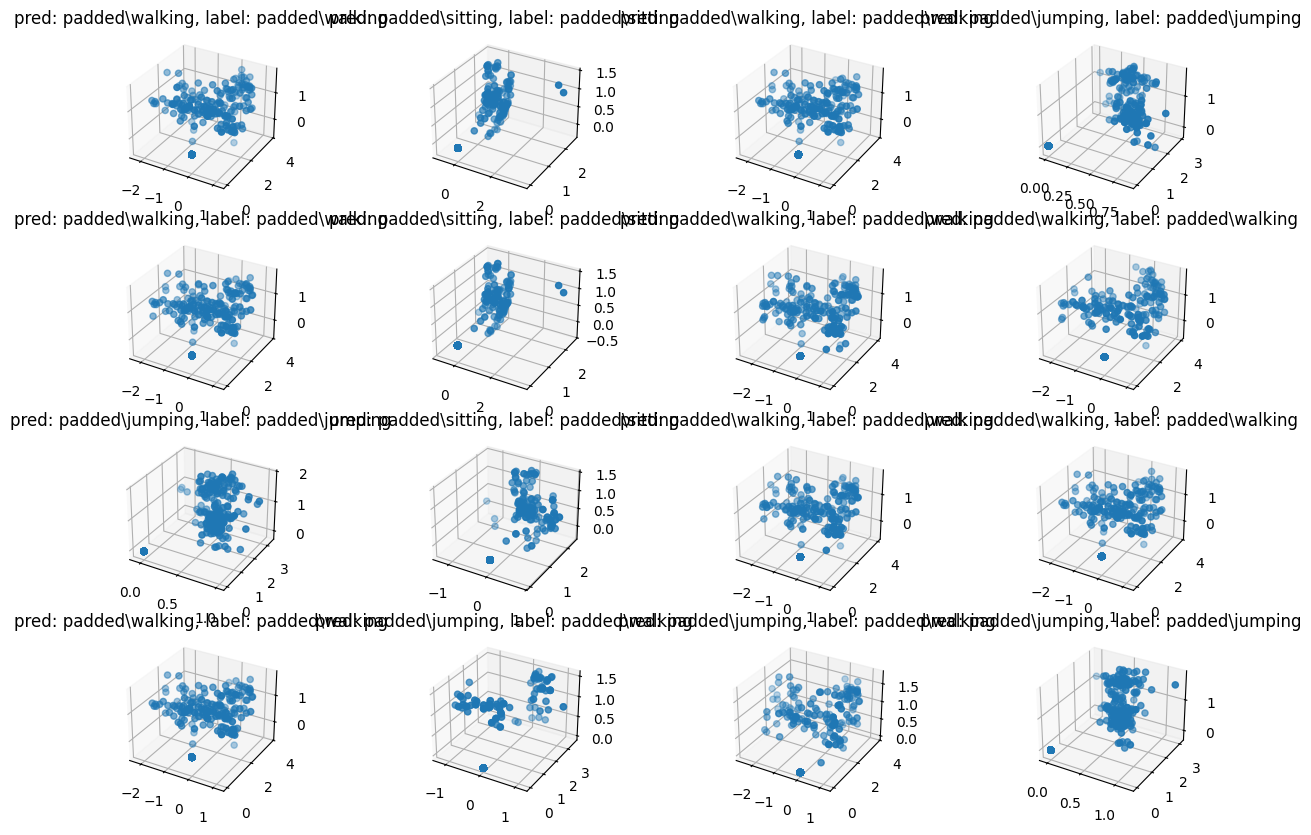

In [43]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_on()
plt.show()

In [44]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)

for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    preds = np.argmax(preds, axis=-1)
    predictions.extend(preds)

predictions = np.array(predictions)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [45]:
accuracy = np.sum(predictions == test_labels) / len(test_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 78.44%


In [46]:
print(test_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3]


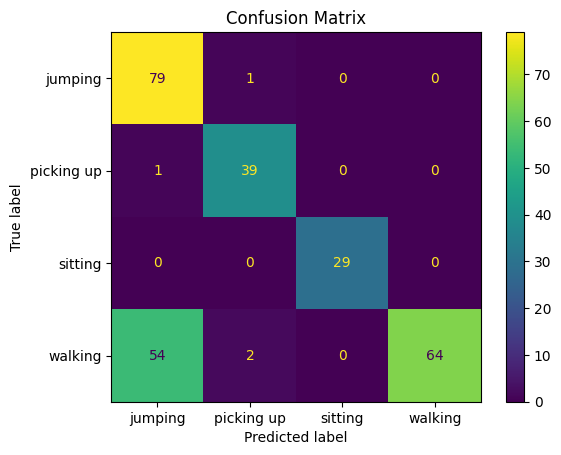

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plotting the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plotting the confusion matrix
class_names = ['jumping', 'picking up', 'sitting', 'walking']  # Based on your CLASS_MAP
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Display the plot
disp.plot()
plt.title("Confusion Matrix")
plt.show()


In [53]:
#reload model
reload_model = create_pointnet_model(input_shape, num_features)
reload_model.load_weights('./model/checkpoints/19_09_2024_pointlstm_4_class_padded_bg_rm/best.weights.h5')

In [82]:
file = 'cluster_data/padded/walking/test/katie_point_taken_poss_matrix154.pkl'
with open(file, 'rb') as file:
    data = pickle.load(file)
    data = np.vstack(data)
    data = data.reshape(1, 300, 5)

In [92]:
np.set_printoptions(threshold=np.inf)
print(data)

[[[-6.56738281e-01  1.06054688e+00  1.13085938e+00 -2.50488281e-01
    3.77000000e+02]
  [-7.04589844e-01  1.12011719e+00  1.18652344e+00 -2.50488281e-01
    3.68000000e+02]
  [-6.60644531e-01  1.04882812e+00  1.18164062e+00 -2.50488281e-01
    3.23000000e+02]
  [-7.51953125e-01  9.69238281e-01  1.04199219e+00  0.00000000e+00
    3.02000000e+02]
  [-7.99804688e-01  1.00585938e+00  1.07128906e+00  0.00000000e+00
    3.03000000e+02]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000

In [83]:
print(reload_model.predict(data))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0.00306202 0.990868   0.00395105 0.00211899]]


In [88]:
def class_preds(DATA_DIR):
    files = glob(os.path.join(DATA_DIR, "[!README]*"))
    for f in files:
        try:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                data = np.vstack(data).reshape(1,300,5)  # Assuming data is a list of arrays
                pred = model.predict(data)
                print(f"Predictions for file {f}: {pred}")

        except Exception as e:
            print(f"Error processing file {f}: {e}")

# Specify your test directory
test_files = './cluster_data/padded/walking/test'
class_preds(test_files)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predictions for file ./cluster_data/padded/walking/test\katie_point_taken_poss_matrix121.pkl: [[0.00917496 0.9840015  0.00421475 0.00260881]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predictions for file ./cluster_data/padded/walking/test\katie_point_taken_poss_matrix135.pkl: [[0.00466192 0.9895139  0.00379816 0.00202603]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predictions for file ./cluster_data/padded/walking/test\katie_point_taken_poss_matrix145.pkl: [[0.8688494  0.11100643 0.0167192  0.00342496]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predictions for file ./cluster_data/padded/walking/test\katie_point_taken_poss_matrix148.pkl: [[0.9817047  0.00573084 0.00568677 0.00687767]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predictions for file ./cluster_data/padded/walking/test\katie_point_taken_poss_matrix154.pkl: [[0.00306202 0.990868   0.00395105 0.00211899]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predictions for file ./cluster_data/padded/walking/test\katie_

In [101]:
#reload model
reload_model = create_pointnet_model(input_shape, num_features, 2)
reload_model.load_weights('./model/checkpoints/17_09_2024_pointnet_bg_rm/best.weights.h5')

ValueError: A total of 11 objects could not be loaded. Example error message for object <Conv1D name=conv1d_52, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(1, 5, 64), Received: value.shape=(1, 5, 32). Target variable: <KerasVariable shape=(1, 5, 64), dtype=float32, path=conv1d_52/kernel>

List of objects that could not be loaded:
[<Conv1D name=conv1d_52, built=True>, <BatchNormalization name=batch_normalization_68, built=True>, <Conv1D name=conv1d_53, built=True>, <BatchNormalization name=batch_normalization_69, built=True>, <Conv1D name=conv1d_54, built=True>, <BatchNormalization name=batch_normalization_70, built=True>, <Conv1D name=conv1d_55, built=True>, <BatchNormalization name=batch_normalization_71, built=True>, <LSTMCell name=lstm_cell, built=True>, <LSTMCell name=lstm_cell, built=True>, <Dense name=dense_39, built=True>]

In [102]:
def class_preds(model, DATA_DIR):
    files = glob(os.path.join(DATA_DIR, "[!README]*"))
    for f in files:
        try:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                data = np.vstack(data).reshape(1,300,5)  # Assuming data is a list of arrays
                pred = model.predict(data)
                print(f"Predictions for file {f}: {pred}")

        except Exception as e:
            print(f"Error processing file {f}: {e}")

# Specify your test directory
test_files = './cluster_data/padded/walking/test'
class_preds(reload_model,test_files)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
Predictions for file ./cluster_data/padded/walking/test\katie_point_taken_poss_matrix121.pkl: [[0.59519327 0.40480673]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predictions for file ./cluster_data/padded/walking/test\katie_point_taken_poss_matrix135.pkl: [[0.5692264  0.43077368]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predictions for file ./cluster_data/padded/walking/test\katie_point_taken_poss_matrix145.pkl: [[0.5710165  0.42898348]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predictions for file ./cluster_data/padded/walking/test\katie_point_taken_poss_matrix148.pkl: [[0.6025031 0.3974969]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predictions for file ./cluster_data/padded/walking/test\katie_point_taken_poss_matrix154.pkl: [[0.54336154 0.45663846]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predictions for file ./cluster_data/padded/walking/test\katie_point_taken_poss_matrix158.pkl: [[0.60651183 0.3934882 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predictions for f